<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [133]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

import torch
from torch.utils.data import DataLoader, TensorDataset

In [134]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [135]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']

positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)  # (10000, 4, 2, 5), (10000, 1, 2, 5), (10000, 5, 1)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features) # (2000, 4, 2, 5), (2000, 1, 2, 5), (2000, 5, 1)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)    # (2000, 4, 2, 5), (2000, 1, 2, 5), (2000, 5, 1)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [136]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0]

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [137]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [138]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

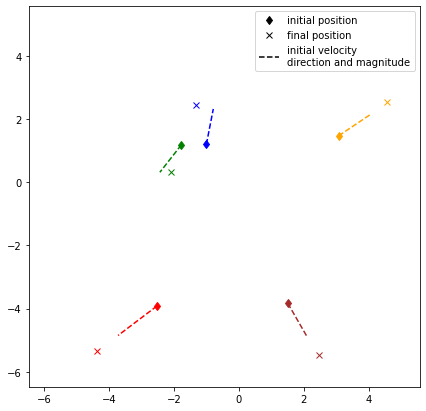

In [139]:
random_idx = np.random.randint(0, 10000)  # 随机生成一个simulation id, plot这个simulation的particals的运动轨迹。每个simulation包含了t=0,0.5,1,1.5这4个时间点的particle的位置
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [140]:
# data preprocessing

velocity_train_data = torch.tensor(velocities_train.reshape(-1, 10), dtype=torch.float) # (sim_dix) -> [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]
charge_train_data = torch.tensor(charges_train.reshape(charges_train.shape[0], -1), dtype=torch.int)  # (sim_dix) -> [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]
position_train_data = torch.tensor(positions_train.reshape(positions_train.shape[0], -1, 10), dtype=torch.float)  # (sim_dix, time) -> -> [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]

velocity_vali_data = torch.tensor(velocities_valid.reshape(-1, 10), dtype=torch.float)
charge_vali_data = torch.tensor(charges_valid.reshape(charges_valid.shape[0], -1), dtype=torch.int)
position_vali_data = torch.tensor(positions_valid.reshape(positions_valid.shape[0], -1, 10), dtype=torch.float)

velocity_test_data = torch.tensor(velocities_test.reshape(-1, 10), dtype=torch.float)
charge_test_data = torch.tensor(charges_test.reshape(charges_test.shape[0], -1), dtype=torch.int)
position_test_data = torch.tensor(positions_test.reshape(positions_test.shape[0], -1, 10), dtype=torch.float)

num_positions = velocity_train_data.shape[-1]   # 10
num_particles = charge_train_data.shape[-1]     # 5
num_times = positions_train.shape[1]            # 4

train_dataset = TensorDataset(velocity_train_data, charge_train_data, position_train_data)
val_dataset = TensorDataset(velocity_vali_data, charge_vali_data, position_vali_data)
test_dataset = TensorDataset(velocity_test_data, charge_test_data, position_test_data)

# sample the training set, take the first n data
num_training_samples = [100, 1000, 2500, 5000, 7500, 10000]
bs = [int(n/100) for n in num_training_samples]
train_datasets = [TensorDataset(velocity_train_data[0:i], charge_train_data[0:i], position_train_data[0:i]) for i in num_training_samples]
train_loaders = [DataLoader(td, batch_size=b) for td, b in zip(train_datasets, bs)]
training_set_names = [f"TRAIN-{name}" for name in num_training_samples]

# base line positions
baseline_train_positions = np.zeros(positions_train.shape)
baseline_val_positions = np.zeros(positions_valid.shape)
baseline_test_positions = np.zeros(positions_test.shape)
for t in range(num_times):
    baseline_train_positions[:, t, :, :] = positions_train[:, 0, :, :] + velocities_train[:, 0, :, :] * t * 0.5
    baseline_val_positions[:, t, :, :] = positions_valid[:, 0, :, :] + velocities_valid[:, 0, :, :] * t * 0.5
    baseline_test_positions[:, t, :, :] = positions_test[:, 0, :, :] + velocities_test[:, 0, :, :] * t * 0.5
baseline_train_positions = torch.tensor(baseline_train_positions.reshape(positions_train.shape[0], -1, 10), dtype=torch.float)
baseline_val_positions = torch.tensor(baseline_val_positions.reshape(positions_valid.shape[0], -1, 10), dtype=torch.float)
baseline_test_positions = torch.tensor(baseline_test_positions.reshape(positions_test.shape[0], -1, 10), dtype=torch.float)

# full training set
train_dataloader = DataLoader(train_dataset, batch_size=100)  # 10000 = 100 * 100

val_dataloader = DataLoader(val_dataset, batch_size=100)      # 2000 = 20 * 100
test_dataloader = DataLoader(test_dataset, batch_size=100)    # 2000 = 20 * 100

In [141]:
from torch import nn

# compute the baseline loss by comparing the baseline position and true position 
def baseline_loss(baseline, true, isTest=False):
    loss_fn = nn.MSELoss()
    if isTest == False:
        return loss_fn(baseline, true).item()
    else:
        # for test dataset, compute the loss by each timestep
        loss = [loss_fn(baseline[:, i, :], true[:, i, :]).item() for i in range(num_times)]
        loss.append(sum(loss)/len(loss))
        return loss

baseline_train_loss = [baseline_loss(baseline_train_positions[0:i], position_train_data[0:i]) for i in num_training_samples]
baseline_val_loss = baseline_loss(baseline_val_positions, position_vali_data)
baseline_test_loss = baseline_loss(baseline_test_positions, position_test_data, isTest=True)
# baseline_train_loss, baseline_val_loss, baseline_test_loss

# Model Implementation

<image src="https://cdn.jsdelivr.net/gh/ruichen-ing/images@master/rnn_v2_train.png" width="800" />


In [142]:
class PreprocessMLP(nn.Module):
    """
    Preprocess velocity, charge, position input and map them to an embedding by a MLP.
    The embedding is the output of MLP and input of LSTM.
    """

    def __init__(self, in_dim, mlp_hidden_dim=16, out_dim=32):
        super().__init__()

        # self.mlp = nn.Sequential(
        #     nn.Linear(in_dim, mlp_hidden_dim),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(mlp_hidden_dim, out_dim),
        #     nn.ReLU(inplace=True)
        # )

        # remove a hidden layer to reduce overfitting
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.mlp(x)

In [143]:
class ParticlePositionPredictor(nn.Module):
    
    def __init__(self,
                 num_positions=num_positions,
                 num_particles=num_particles,
                 mpl_hidden_dim=16,
                 embed_dim=32, 
                 hidden_dim=32, 
                 num_layers=1,
                 hidden_dense_dim=64,
                 dense_dropout=0.4):

        '''
        mpl_hidden_dim: hidden layer dim in MLP
        embed_dim: embedding size of velocity, charge, position = output size of MLP block = input size of LSTM
        hidden_dim: size of LSTM hidden layer
        num_layers: number of hidden layers in each LSTM
        hidden_dense_dim: size of the dense layer after LSTM
        dense_dropout: rate for dropout layer after the dense layer
        '''
        
        super(ParticlePositionPredictor, self).__init__()

        self.embed_dim = embed_dim
        self.num_positions = num_positions
        self.num_particles = num_particles

        self.speedMLP = PreprocessMLP(num_positions, mpl_hidden_dim, self.embed_dim)
        self.chargeMLP = PreprocessMLP(num_particles, mpl_hidden_dim, self.embed_dim)
        self.positionMLP = PreprocessMLP(num_positions, mpl_hidden_dim, self.embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)  # batch_size, hidden_dim

        self.f0 = nn.Linear(hidden_dim, hidden_dense_dim)
        self.relu = nn.ReLU()

        # Actually dropout it is not used due to performance degradation
        self.drop = nn.Dropout(p=dense_dropout)

        # Map to number of positions needed to be predicted
        self.f1 = nn.Linear(hidden_dense_dim, num_positions)
        
        # No need of an additional activation layer, because it is a regression task
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())  # weight_decay insreases loss dramatically,
    
    def forward(self, velocities, charges, positions):
        """
        Forward pass of trainable model. It predicts each next word
        in the descriptive sentence as if the previous word was correct
        by substitution of the ground truth word for the previous word.

        Input:
        charges: (batch_size, num_particles) num_particles = 5
        velocities: (batch_size, num_positions) num_positions = 10 -> 5x + 5y
        posiitons: (batch_size, num_positions) num_positions = 10

        Outputs:
        output: (batch_size, num_times + 1, num_positions), num_times = 4 , num_positions = 10
        """

        velocity_vector = self.speedMLP(velocities)
        velocity_vector = velocity_vector.unsqueeze(1) 
        charge_vector = self.chargeMLP(charges.type(torch.FloatTensor))
        charge_vector = charge_vector.unsqueeze(1)
        position_embedding = self.positionMLP(positions)

        # Remove the position of the last time point
        position_embedding = position_embedding[:, :-1,:]   # batch_size, time, embedding

        # Concatenate all our inputs -> velocity, charge and position
        concat_embeddings = torch.cat([velocity_vector, charge_vector, position_embedding], dim=1)

        # Feed packed input sequence to rnn
        # return: output, (hn, cn)
        rnn_output, _ = self.rnn(concat_embeddings)

        output = self.f0(rnn_output)

        output = self.relu(output)

        # Dropout is not used in the final model
        output = self.drop(output)

        output = self.f1(output) #(batch_size, num_time + 1, 10), 10 -> 5 positions(x, y)

        # we remove the first two outputs as it corresponds to initial speed and charge
        # we only need the prediction on t = 0.5, 1.0, 1.5. We do not need to predict for position on t = 0
        output = output[:, 2:] #(batch_size, num_time -1, 10)
        return output
        

# Model Training

In [144]:
import time

def train(dataloader, model):
    model.train()
    num_data = 0
    total_loss = 0

    for charges, velocities, positions in dataloader:
        charges = charges.to(device)
        velocities = velocities.to(device)
        positions = positions.to(device)
        
        model.optimizer.zero_grad()

        # prediction on t = 0.5, 1.0, 1.5
        y_pred = model(charges, velocities, positions)
        
        # y_true: crop the true positions, as we only need the last 3 positions
        y_true = positions[:, 1:, :]
        loss = model.criterion(y_pred, y_true)

        num_data += positions.shape[0]
        total_loss += loss.item()
        
        loss.backward()
        
        # set a gradient threshold to avoid exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()

    return total_loss/num_data

def evaluate(dataloader, model):
    model.eval()
    num_data = 0
    total_loss = 0

    with torch.no_grad():
        for charges, velocities, positions in dataloader:
            
            charges = charges.to(device)
            velocities = velocities.to(device)
            positions = positions.to(device)

            y_pred = model(charges, velocities, positions)
            y_true = positions[:, 1:, :]
            loss = model.criterion(y_pred, y_true)

            num_data += positions.shape[0]
            total_loss += loss.item()

    return total_loss/num_data

In [145]:
from tqdm import tqdm

EPOCHS = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
model_0 = ParticlePositionPredictor(
                 mpl_hidden_dim=16,
                 embed_dim=16, 
                 hidden_dim=16, # output size of MLP, input size of LSTM, embedding size of velocity, charge, position
                 num_layers=1,
                 hidden_dense_dim=16,
                 dense_dropout=0).to(device)  # dropout increases training loss dramatically such that validation loss and test loss are lower than training loss! Thus, dropout is removed.

# list of models, each one for a training set
models = [ParticlePositionPredictor(mpl_hidden_dim=16, embed_dim=16, hidden_dim=16, num_layers=1, hidden_dense_dim=16, dense_dropout=0).to(device) for i in range(len(num_training_samples))]

def train_val(idx, model):

    train_loss, val_loss = [], []
    print(f"Training and validation for training set {training_set_names[idx]}:")
    for epoch in tqdm(range(1, EPOCHS + 1)):
        epoch_start_time = time.time()

        train_loss.append(train(train_dataloader, model))
        val_loss.append(evaluate(val_dataloader, model))
        
    #     print('-' * 80)
    #     print('| end of epoch {:3d} | time: {:5.2f}s | '
    #         'train loss: {:5.3f}    '
    #         'validation loss: {:5.3f}'.format(epoch,
    #                                     time.time() - epoch_start_time, 
    #                                     train_loss[-1],
    #                                     val_loss[-1]))
    #     print('-' * 80)
    # print()
    print('-' * 80)

    return train_loss, val_loss

train_val_loss = [train_val(i, m) for i, m in enumerate(models)]

Training and validation for training set TRAIN-100:


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


--------------------------------------------------------------------------------
Training and validation for training set TRAIN-1000:


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


--------------------------------------------------------------------------------
Training and validation for training set TRAIN-2500:


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


--------------------------------------------------------------------------------
Training and validation for training set TRAIN-5000:


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


--------------------------------------------------------------------------------
Training and validation for training set TRAIN-7500:


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


--------------------------------------------------------------------------------
Training and validation for training set TRAIN-10000:


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]

--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Training loss,Vaidation loss
TRAIN-100,0.001761,0.001756
TRAIN-1000,0.001712,0.001677
TRAIN-2500,0.000617,0.000583
TRAIN-5000,0.001520,0.001312
TRAIN-7500,0.000731,0.000743
TRAIN-10000,0.003118,0.002965
Baseline,0.236938,0.237509


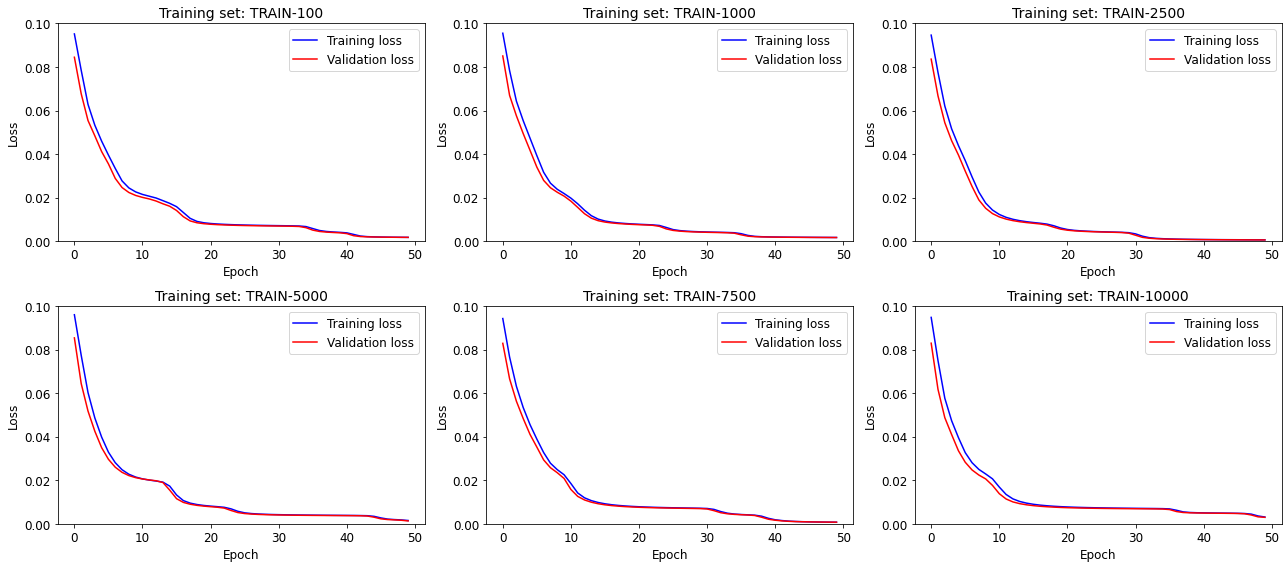

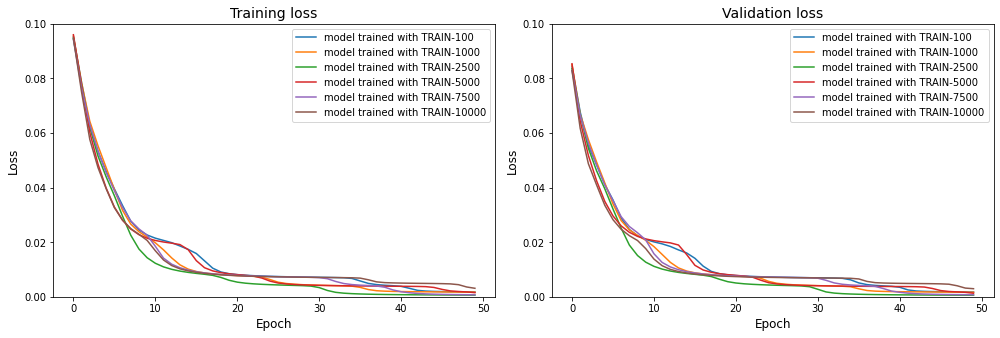

In [155]:
from numpy.ma.core import ceil
import pandas as pd

def plot_loss(idx, ax, train_loss, val_loss):
    fnt=12
    ax.plot(train_loss, color='blue', label='Training loss')
    ax.plot(val_loss, color='red', label='Validation loss')
    # ax.axhline(y=baseline_train_loss[idx], color="grey", linestyle="--", label="Training baseline")
    ax.set_title(f"Training set: {training_set_names[idx]}", fontsize=14)
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)

    ax.set_ylim([0, 0.10])
    ax.set_xlabel("Epoch", fontsize=fnt)
    ax.set_ylabel("Loss", fontsize=fnt);

def plot_loss_comparison(ax, loss, isVal=False):
    fnt=12
    for name, _loss in zip(training_set_names, loss):
        ax.plot(_loss, label=f"model trained with {name}")
    if isVal == False:
        base = sum(baseline_train_loss)/len(baseline_train_loss)
        # ax.axhline(y=base, color="grey", linestyle="--", label="average baseline")
        ax.set_title(f"Training loss", fontsize=14)
    else:
        # ax.axhline(y=baseline_val_loss, color="grey", linestyle="--", label="average baseline")
        ax.set_title(f"Validation loss", fontsize=14)
    ax.set_ylim([0, 0.10])
    ax.set_xlabel("Epoch", fontsize=fnt)
    ax.set_ylabel("Loss", fontsize=fnt);
    ax.legend()
    

def report_loss(train_val_loss, save=False):
    cols = []
    train_losses = []
    val_losses = []
    fig, axes = plt.subplots(int(ceil(len(num_training_samples)/3)), 3, figsize=(18, 8))
    for i, (t, v) in enumerate(train_val_loss):
        cols.append([training_set_names[i], t[-1], v[-1]])
        train_losses.append(t)
        val_losses.append(v)
        plot_loss(i, axes[int(i/3), i%3], t, v)
    fig.tight_layout()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4.8))
    plot_loss_comparison(axes[0], train_losses)
    plot_loss_comparison(axes[1], val_losses, isVal=True)
    fig.tight_layout()

    cols.append(['Baseline', sum(baseline_train_loss)/len(baseline_train_loss), baseline_val_loss])
    df = pd.DataFrame (cols, columns = ['Training set', 'Training loss', 'Vaidation loss'])
    df = df.set_index(['Training set'])
    df.index.name = None

    if save == True:
        from google.colab import files
        name = f"train_val_loss_{int(time.time())}"
        plt.savefig(f"{name}.png", bbox_inches='tight', dpi=300)
        files.download(f"{name}.png")
        df.to_csv(f'{name}.csv')
        files.download(f'{name}.csv')

    return df

report_loss(train_val_loss, save=False)

In [147]:
model_0 = models[-1]
def get_predicted_positions(dataloader, model):
    '''
    get the predicted positions per particle per simulation at t = 0.5, 1.0, 1.5
    only for training set and validation set
    for test set: use evaluate() method
    '''
    model.eval()
    init = []
    latter = []
    pred = []

    with torch.no_grad():
        for charges, velocities, positions in dataloader:
            charges = charges.to(device)
            velocities = velocities.to(device)
            positions = positions.to(device)

            y_pred = model(charges, velocities, positions)
            y_pred = y_pred.cpu().detach().numpy()   # (100, 3, 10)
            first = positions[:, 0, :].unsqueeze(1).cpu().detach().numpy() #(100, 1, 10)
            init.extend(first)
            latter.extend(y_pred)

    for i in range(len(init)):
        pred.extend(np.concatenate((init[i], latter[i])))
    
    return np.array(pred).reshape(-1, num_times, 2, num_particles)

pred_train_positions = get_predicted_positions(train_dataloader, model_0)
pred_train_positions_lists = [get_predicted_positions(tl, m) for tl, m in zip(train_loaders, models)]   # get predictions for each training set

In [148]:
import matplotlib.colors as mc
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import colorsys
import random

markers = ["x", "o", "s", "^"]
colors = ["yellowgreen", "royalblue", "orange", "mediumorchid", "tomato", "crimson", "grey"]
factors = [1.6, 1.4, 1.6, 1.4, 1.4]

def adjust_lightness(color, amount=0.5):
    '''
    helper function to change scatter color
    '''
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


def plot_prediction(sim_idx, pred_positions, true_positions, name, save=False, isTest=False):
    fig, axes = plt.subplots(1, len(sim_idx), figsize=(20, 5))
    if isTest == False:
        fig.suptitle(f"Model trained with {name}: Training prediction and true positions", fontsize=14)
    else:
        fig.suptitle(f"Model trained with {name}: Test prediction and true positions", fontsize=14)
    # custom legend
    patch_list = []
    for i, c in zip(range(num_particles) ,colors):
        patch_list.append(mpatches.Patch(color=adjust_lightness(c, 1.1), label=f'Predicted particle {i}', hatch='*'))
        patch_list.append(mpatches.Patch(color=adjust_lightness(c, factors[i]), label=f'True particle {i}', hatch='*'))
    patch_list.extend([mlines.Line2D([], [], color='black', marker=m, linestyle='None',
                        markersize=5, label=f'Positions at t={i*0.5}') for i, m in enumerate(markers)])

    for ax, id in zip(axes, sim_idx):
        pred = pred_positions[id]   # (4, 2, 5)
        true = true_positions[id]   # (4, 2, 5)

        # fig, ax = plt.subplots(1,1, figsize=(7, 4.5))
        for p_id in range(num_particles):
            for time_dix in range(num_times):

                x_pred = pred[:,:,p_id][time_dix, 0]
                y_pred = pred[:,:,p_id][time_dix, 1]
                x_true = true[:,:,p_id][time_dix, 0]
                y_true = true[:,:,p_id][time_dix, 1]

                ax.scatter(x_pred, y_pred, s=30, color=adjust_lightness(colors[p_id], 1.1), marker=markers[time_dix], label=f't={time_dix*0.5}: prediction')
                ax.scatter(x_true, y_true, s=30, color=adjust_lightness(colors[p_id], factors[p_id]), marker=markers[time_dix], label=f't={time_dix*0.5}: true position')
                ax.set_title(f"Simulation {id}")
                
        fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
        axes.flatten()[-1].legend(handles=patch_list, loc='upper center', bbox_to_anchor=(-0.7, -0.1), ncol=7)
        # ax.legend(handles=patch_list, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.subplots_adjust(top=0.85)

        if save == True:
            from google.colab import files
            prefix = ""
            if isTest == False:
                prefix = "Training"
            else:
                prefix = "Test"
            plt.savefig(f"{prefix}_sim_{id}.png", bbox_inches='tight', dpi=300)
            files.download(f"{prefix}_sim_{id}.png")

    if save == False:
        plt.show()


The MES losses show that for each training set the corresponding model has been trained well. Let's plot the predicted positions and the true positions for each trained model to have a more straightforward comparison.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

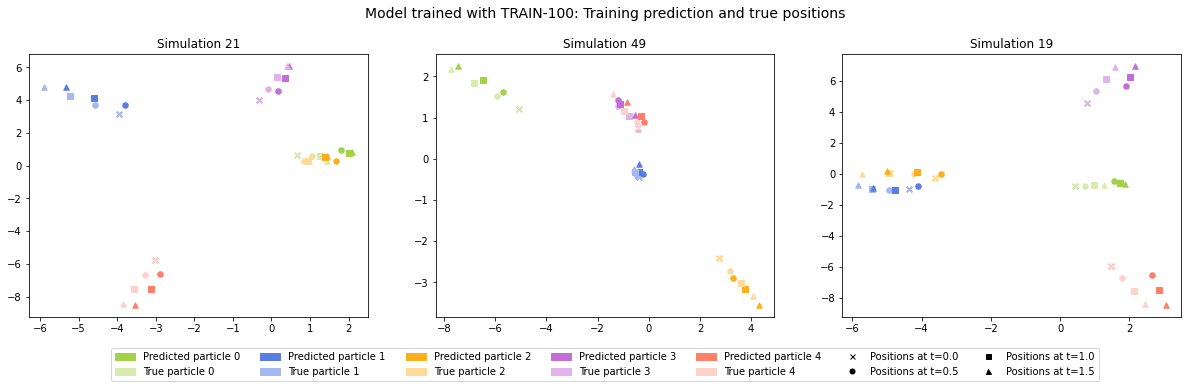

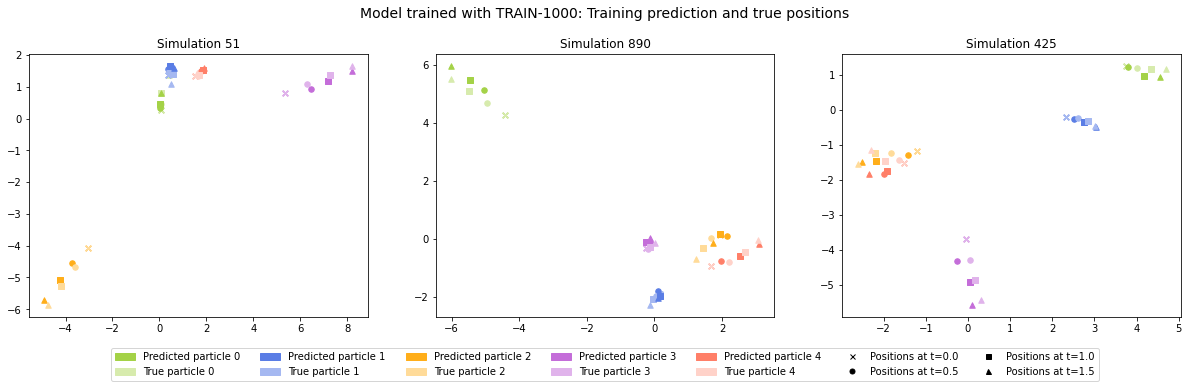

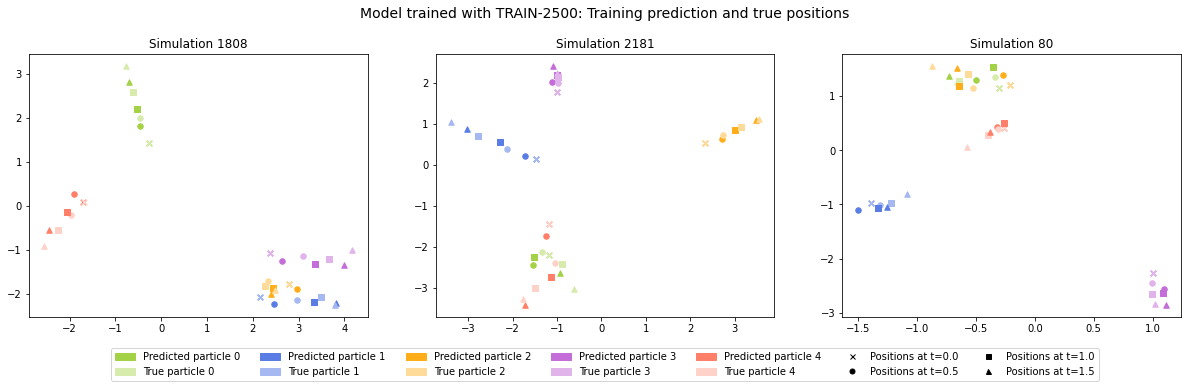

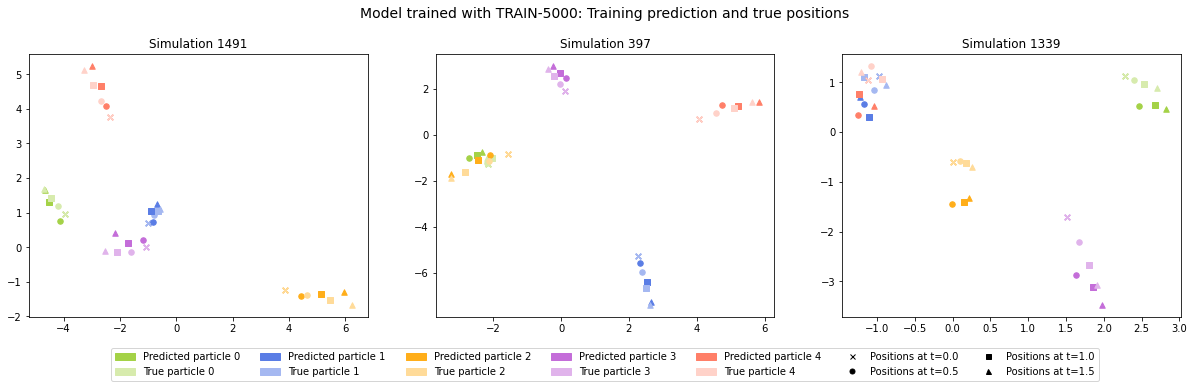

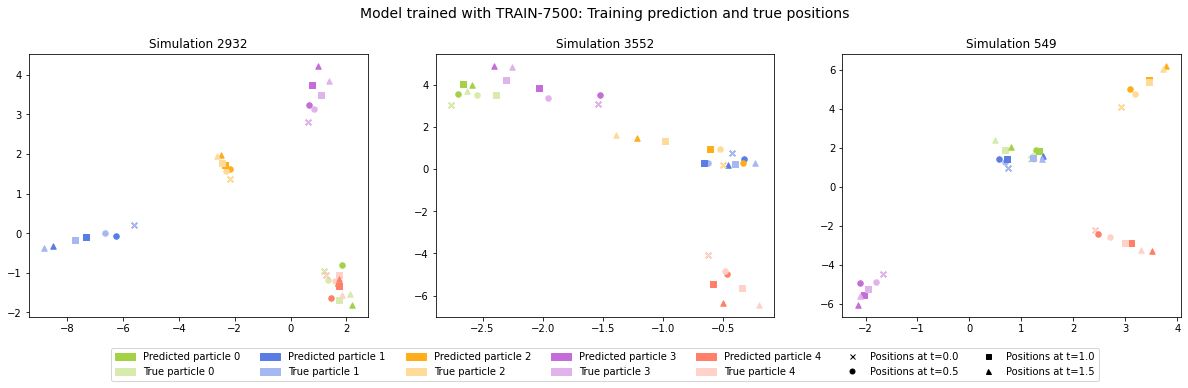

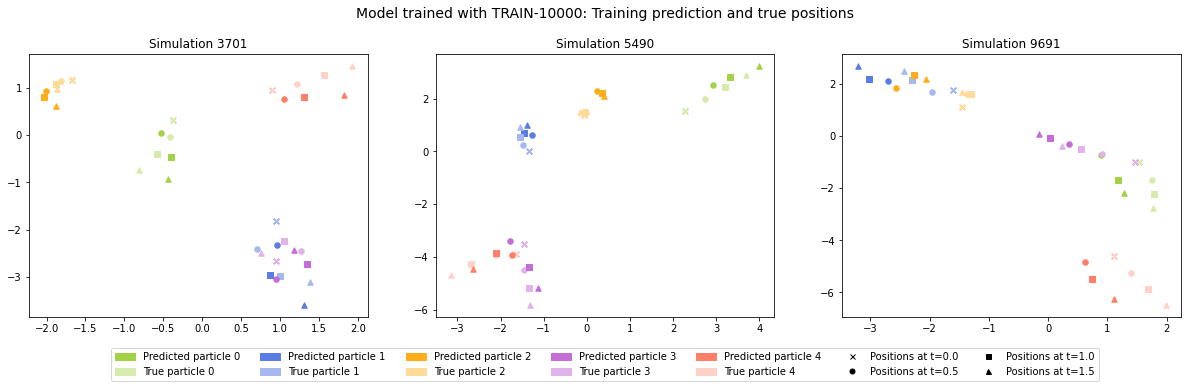

In [156]:
# plot 3 random simulations of training set
for i, num in enumerate(num_training_samples):
    idx = random.sample(range(num), 3)
    plot_prediction(idx, pred_train_positions_lists[i], positions_train[0:num], save=False, name=training_set_names[i])

# Evaluation

In the above section, we obtain the predicted positions by feeding the positions at all time points $t\in\{0, 0.5, 1.0, 1.5\}$. Then, the loss is calculated by comparing the predictions and the true values. This approach is the same as how we treat validation set that we don't use the predicted position at the last timestep to be the input position at next timestep.

To better evaluate the model, in the following section we only feed the initial position of the particles and get the predicted positions at $t\in\{0.5, 1.0, 1.5\}$. That is, regarding output target position at each timestep as the correct position, and putting it into the model as the start position for the next turn.

<image src="https://cdn.jsdelivr.net/gh/ruichen-ing/images@master/rnn_v2_evaluate2.png" width=700 />

In [150]:
class Evaluator():
    '''
    Get the position at the next time point by using the last predictions as the input in next timestep
    '''

    def __init__(self, init_positions, velocity, charge, model=model_0, num_times=num_times):
        self.trained_model = model
        self.num_times = num_times
        self.true_data = init_positions
        self.velocities = velocity
        self.charges = charge
        
    def evaluate(self):
        '''
        manually go through MLP and LSTM to get predictions
        intput: velocity, charge, init_positions(t = 0)
        output: predicted positions at t = 0.5, 1.0, 1.5
                return a list with size = 3, each element of list is a tensor with the size (dataset_dim, 1, num_positions)
                for test dataset, dataset_dim = 2000
        '''
        self.trained_model.train()
        
        with torch.no_grad():
            velocity_vector = self.trained_model.speedMLP(self.velocities)
            velocity_vector = velocity_vector.unsqueeze(1)

            charge_vector = self.trained_model.chargeMLP(self.charges.type(torch.FloatTensor))
            charge_vector = charge_vector.unsqueeze(1)

            rnn_eval = self.trained_model.rnn.eval()

            # pass the first two timesteps, i.e. velocity and charge 
            # We don't need the output but the hidden state, which will then be fed into the model and processed with the first timestep input
            # hx: hidden state from the previous timestep
            _, rnn_state = rnn_eval(input=velocity_vector, hx=None)
            _, rnn_state = rnn_eval(input=charge_vector, hx=rnn_state)

            pred_positions = []
            for t in range(self.num_times - 1):
                if t == 0:
                  # Use the initial position to get the first position prediction
                  position_embedding = self.trained_model.positionMLP(self.true_data[:, 0, :])   # (batch_size, num_positions)
                  position_embedding = position_embedding.unsqueeze(1)    # (batch_size, 1, num_positions)
                else:
                  # Last predicted position as next input
                  position_embedding = self.trained_model.positionMLP(pred_positions[-1])
                
                rnn_output_next_position, rnn_state = rnn_eval(input=position_embedding.to(device), hx=rnn_state)

                rnn_output_next_position = self.trained_model.f0(rnn_output_next_position)
                rnn_output_next_position = self.trained_model.relu(rnn_output_next_position)

                # Map to num_positions entries which enables predicting next position of particles
                pred_next_position = self.trained_model.f1(rnn_output_next_position)
                
                pred_positions.append(pred_next_position)

                self.pred = pred_positions


    def loss(self):
        '''
        Calculate MSE loss by comparing predicted positions with true test positions
        '''
        # Call evaluate() first to compute predicted positions and store it in self.pred
        self.evaluate()

        _pred_positions = torch.zeros(self.true_data.shape)

        for i in range(num_times):
            if i == 0:
                # The initial position of prediction is the same as the true one, because it is the necessary input for subsequent predictions.
                _pred_positions[:, i, :] = self.true_data[:, 0, :]
            else:
                _pred_positions[:, i, :] = self.pred[i - 1].reshape(-1, num_positions)
        
        loss_fn = nn.MSELoss()
        loss = [loss_fn(_pred_positions[:, i, :], self.true_data[:, i, :]).item()
                    for i in range(num_times)]
        loss.append(loss_fn(_pred_positions, self.true_data).item())

        return _pred_positions, loss

Now we calculate the loss by comparing the distance between the predicted positions of each data sample in the test set and the true test values. The following table shows the MSE loss for each model trained with different training set by each timestep.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TRAIN-100,TRAIN-1000,TRAIN-2500,TRAIN-5000,TRAIN-7500,TRAIN-10000,Test baseline
t = 0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
t = 0.5,0.188408,0.177873,0.057348,0.157296,0.082137,0.315706,0.057905
t = 1.0,0.333923,0.320453,0.179263,0.310518,0.218280,0.470409,0.258769
t = 1.5,0.588572,0.569010,0.393976,0.590145,0.460986,0.764005,0.607064
Average,0.277726,0.266834,0.157647,0.264490,0.190351,0.387530,0.230934


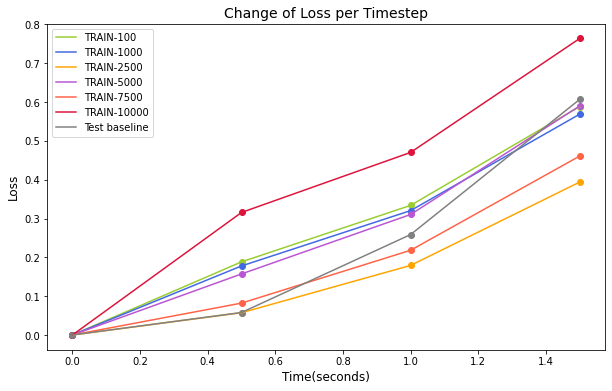

In [163]:
# Input: initial speed, charge, initial position(t = 0)
evaluators = [Evaluator(position_test_data, velocity_test_data, charge_test_data, m, num_times) for m in models]
test_predictions = [evaluator.loss() for evaluator in evaluators]       # len=len(models), (pred_positions, loss)

def report_test_loss(save=False):
    losses = np.array([loss for _, loss in test_predictions])
    cols = [losses[:, i] for i in range(losses.shape[1])]
    df = pd.DataFrame (cols, columns = training_set_names)
    ts = [f"t = {t*0.5}" for t in range(num_times)]
    ts.append("Average")
    df["Timestep"] = ts
    df["Test baseline"] = baseline_test_loss
    df = df.set_index(['Timestep'])
    df.index.name = None

    labels = df.columns.tolist()
    x_t = [t*0.5 for t in range(num_times)]
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for i, label in enumerate(labels):
        ax.scatter(x_t, df[label][:-1].values, c=colors[i])
        ax.plot(x_t, df[label][:-1].values, label=label, c=colors[i])
    ax.set_title("Change of Loss per Timestep", fontsize=14)
    ax.set_xlabel("Time(seconds)", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.legend(loc="upper left");

    if save == True:
        from google.colab import files
        name = f"test_loss_{int(time.time())}"
        plt.savefig(f"{name}.png", bbox_inches='tight', dpi=300)
        files.download(f'{name}.png')
        df.to_csv(f'{name}.csv')
        files.download(f'{name}.csv')
    return df

report_test_loss(save=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

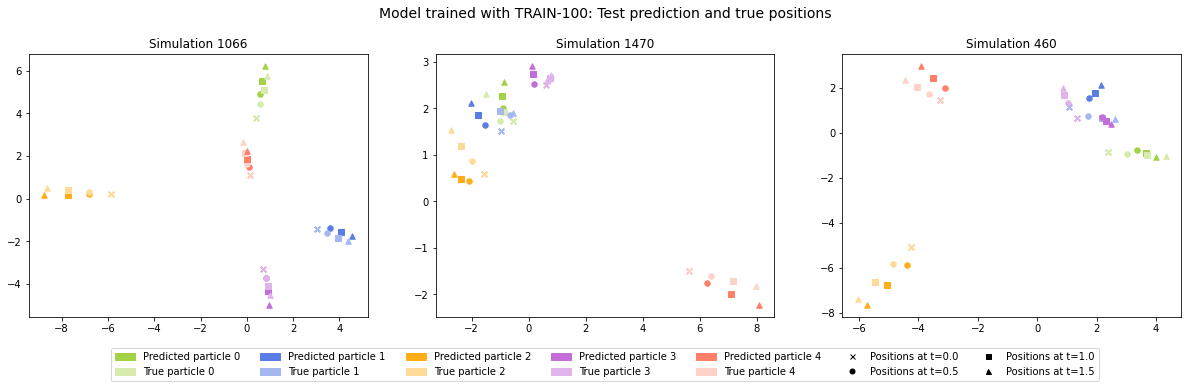

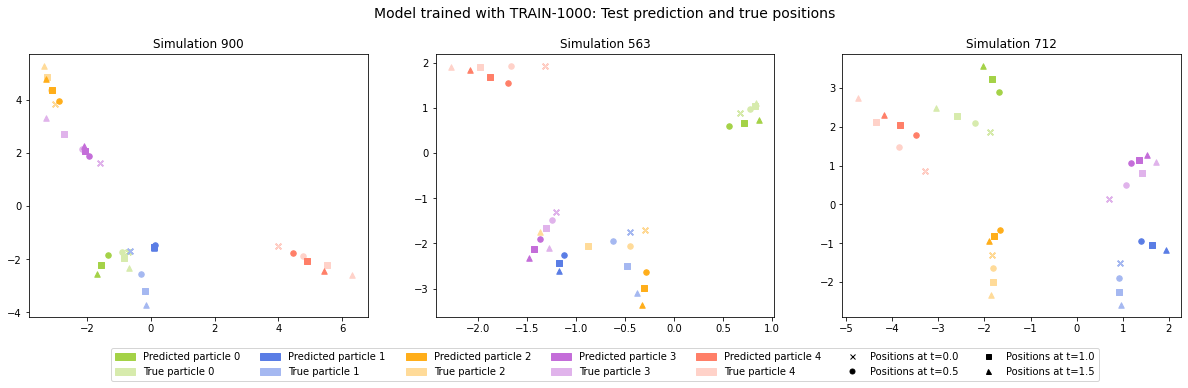

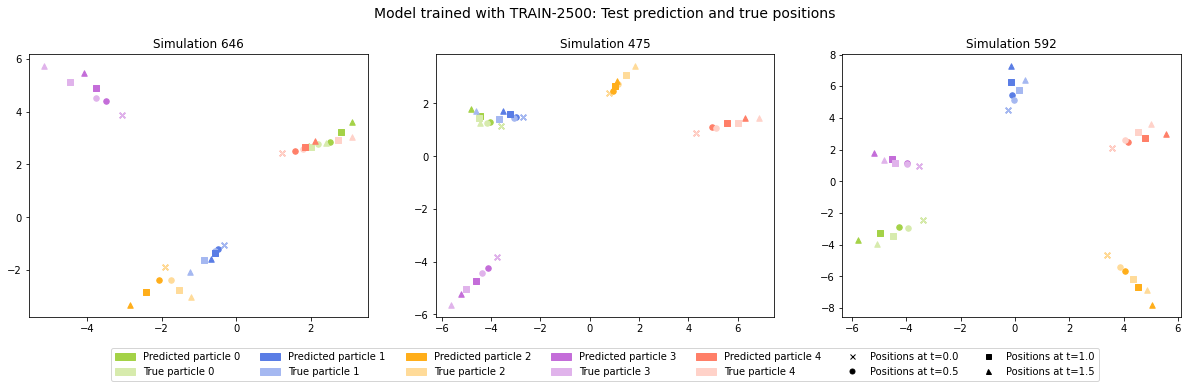

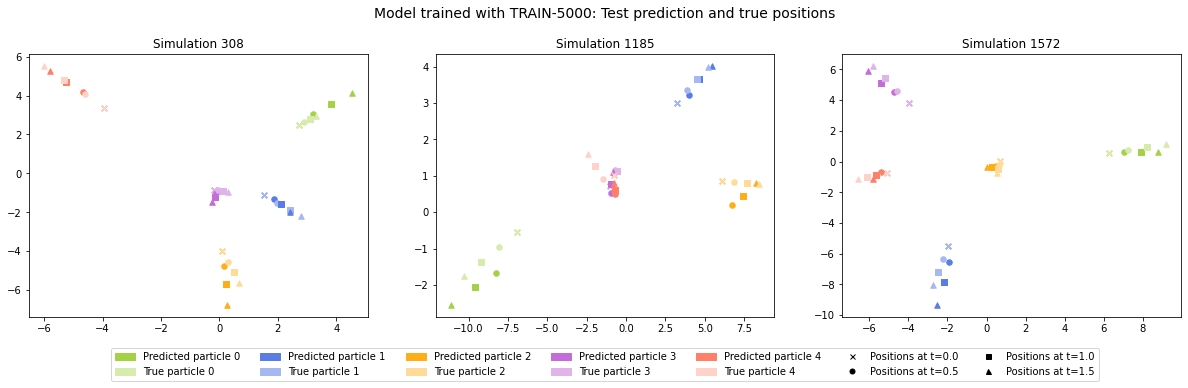

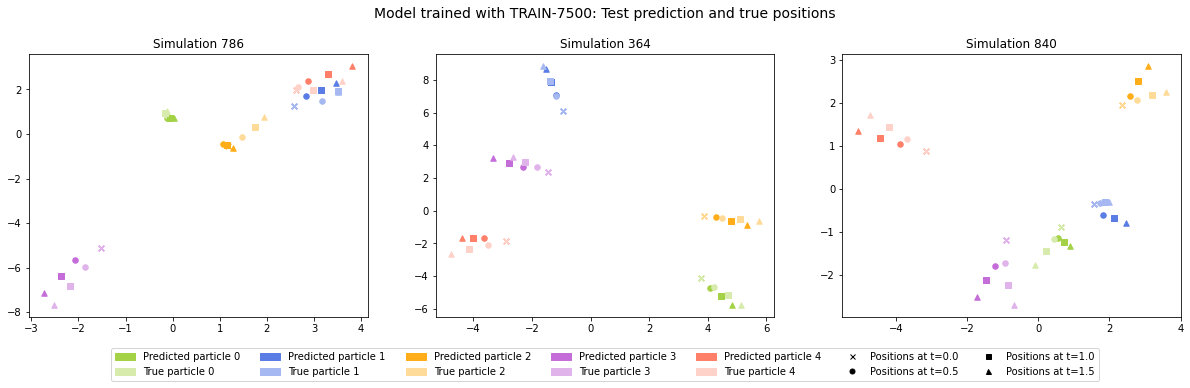

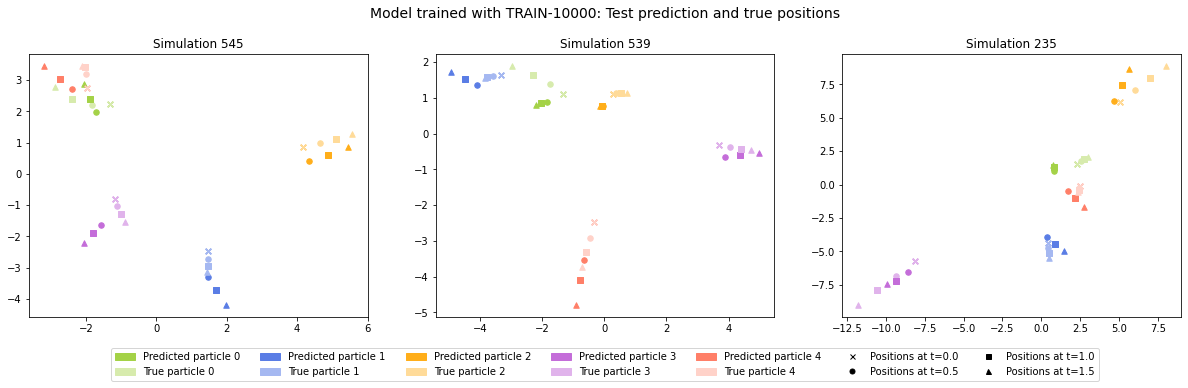

In [165]:
# plot 3 simulations(test set)
def plot_test_predictions():
    # for each prediction generated by a trained model
    for i, (pred, _) in enumerate(test_predictions):
        pp = pred.reshape(pred.shape[0], num_times, -1, num_particles)   # change the dimension to the same of positions_test
        idx = random.sample(range(positions_test.shape[0]), 3)
        plot_prediction(idx, pp, positions_test, save=True, isTest=True, name=training_set_names[i])

plot_test_predictions()

In [157]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [159]:
def save_models():
    for i, m in enumerate(models):
        torch.save(m.state_dict(), f'/content/drive/MyDrive/Deep-Learning/save_models/{training_set_names[i]}_{int(time.time())}.pth')

# save_models()